<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  1000 non-null   object
 1   user_id    1000 non-null   int64 
 2   action     1000 non-null   object
 3   resource   1000 non-null   object
 4   label      1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    1000 non-null   object
 1   user_id      1000 non-null   int64 
 2   auth_method  1000 non-null   object
 3   status       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  -----

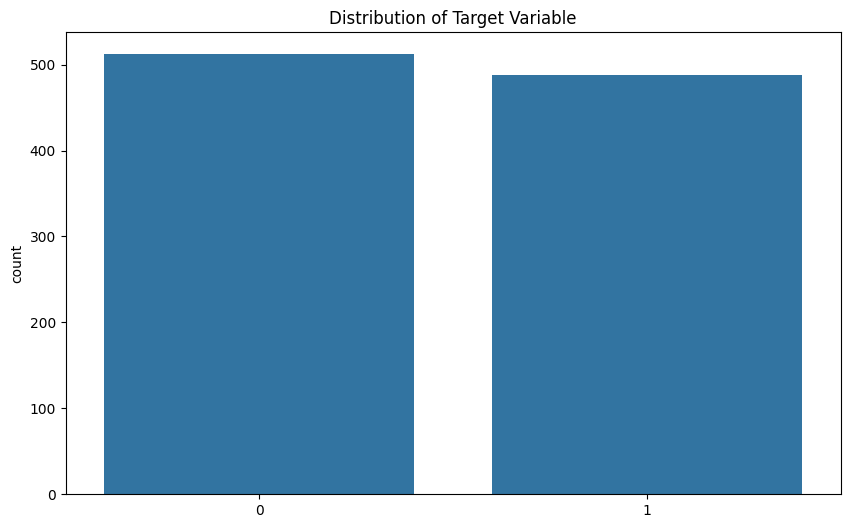

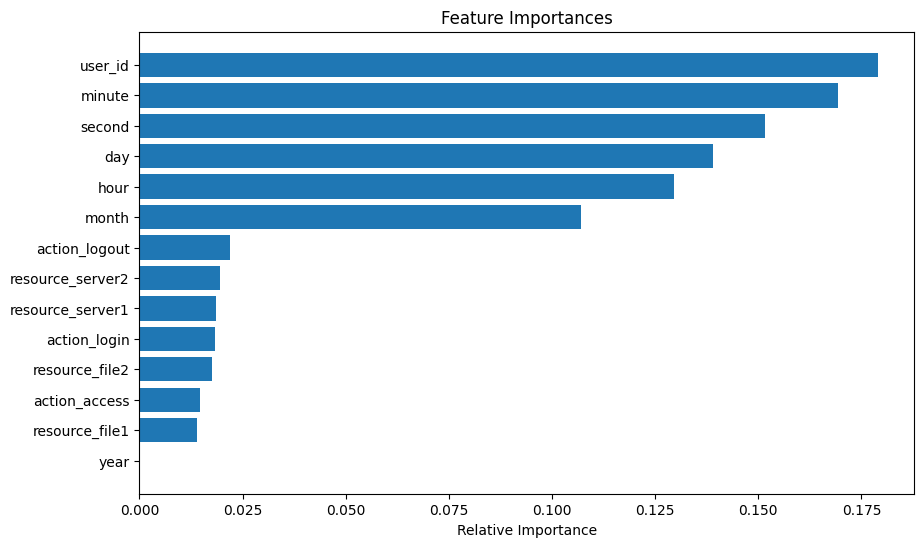

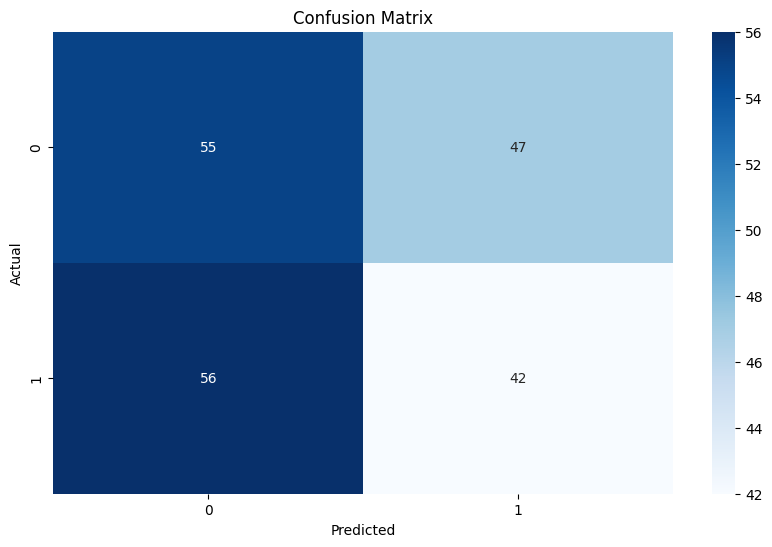

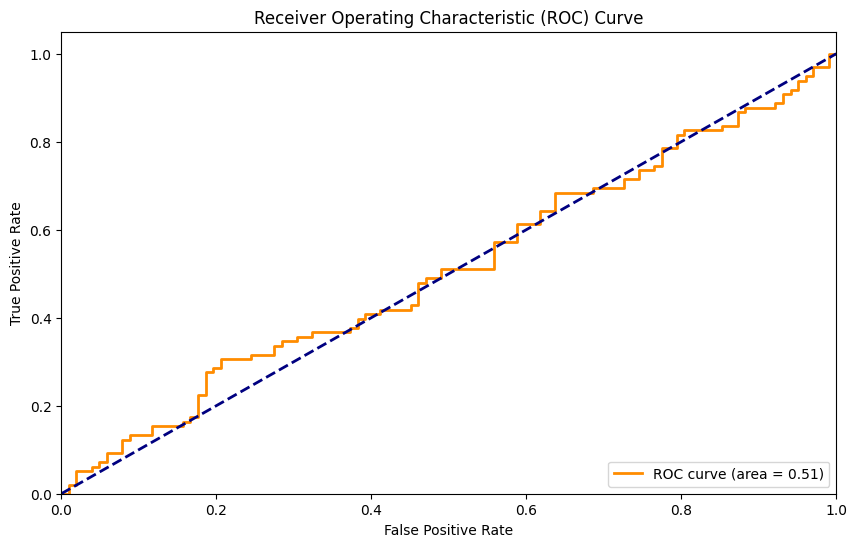

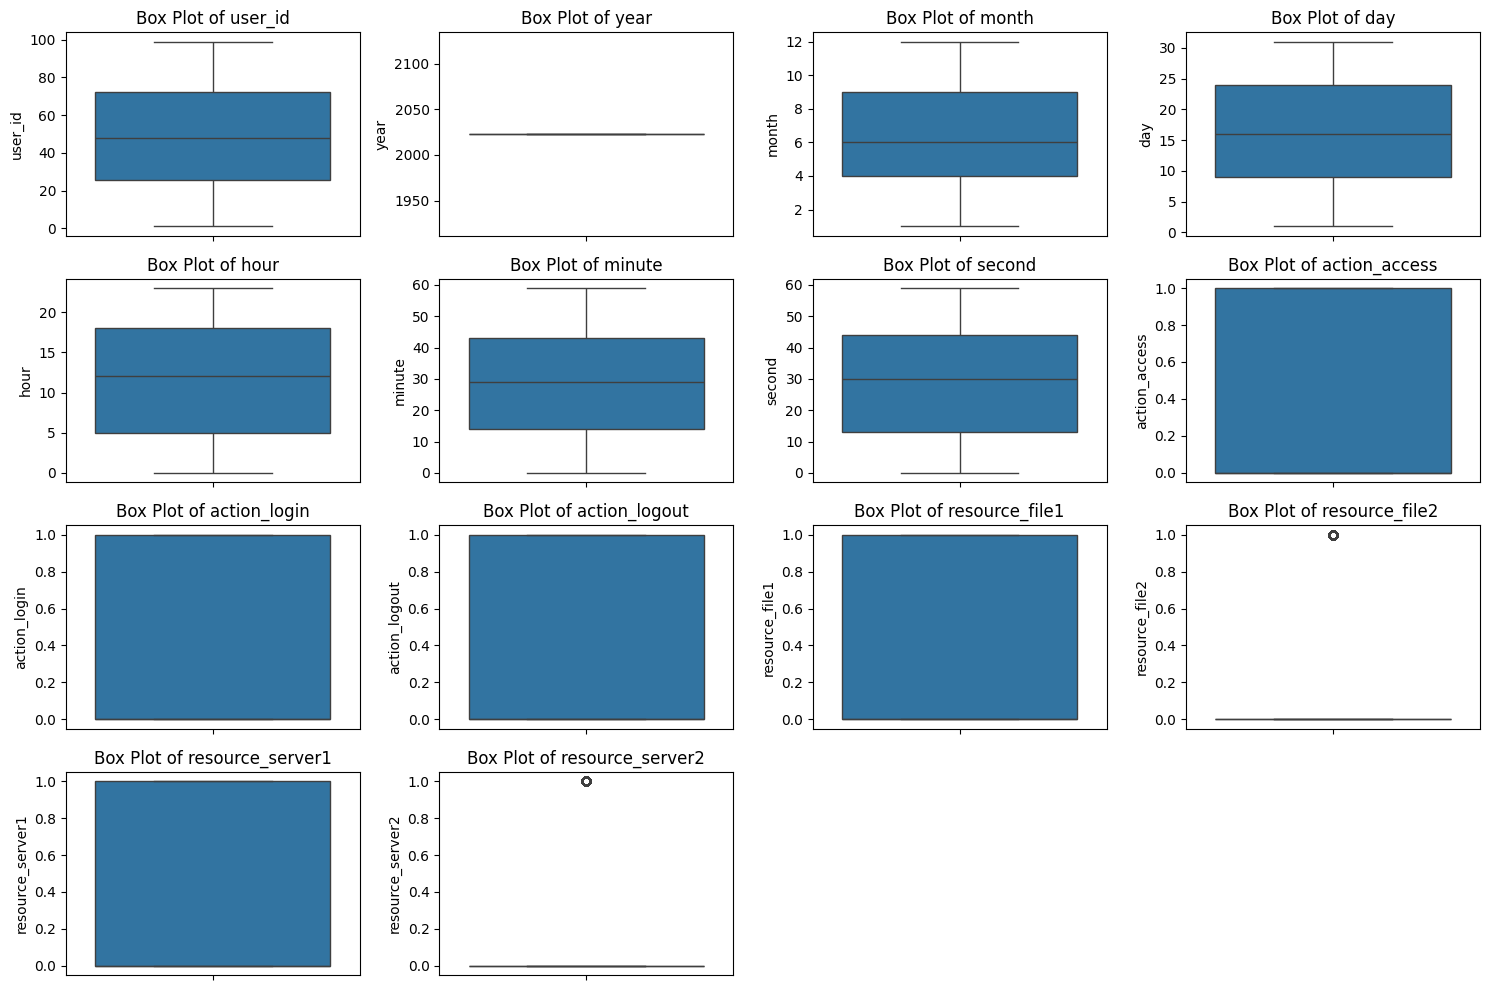

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Define the path to the training data
train_data = 'extraction/train_data'

# Load each CSV file into separate dataframes
access_logs_df = pd.read_csv(os.path.join(train_data, 'access_logs.csv'))
auth_logs_df = pd.read_csv(os.path.join(train_data, 'auth_logs.csv'))
network_logs_df = pd.read_csv(os.path.join(train_data, 'network_logs.csv'))

# Display basic info of each dataframe to understand structure and available features
print(access_logs_df.info())
print(auth_logs_df.info())
print(network_logs_df.info())

# Display first few rows of each dataframe for further exploration
print(access_logs_df.head())
print(auth_logs_df.head())
print(network_logs_df.head())

# Preprocess the data
# Convert timestamp to datetime
access_logs_df['timestamp'] = pd.to_datetime(access_logs_df['timestamp'])

# Extract features from timestamp
access_logs_df['year'] = access_logs_df['timestamp'].dt.year
access_logs_df['month'] = access_logs_df['timestamp'].dt.month
access_logs_df['day'] = access_logs_df['timestamp'].dt.day
access_logs_df['hour'] = access_logs_df['timestamp'].dt.hour
access_logs_df['minute'] = access_logs_df['timestamp'].dt.minute
access_logs_df['second'] = access_logs_df['timestamp'].dt.second

# Drop the original timestamp column
access_logs_df = access_logs_df.drop('timestamp', axis=1)

# One-hot encode categorical features
access_logs_df = pd.get_dummies(access_logs_df, columns=['action', 'resource'])

# Assuming 'label' is the target column and the rest are features
X = access_logs_df.drop('label', axis=1)
y = access_logs_df['label']

# Encode labels if necessary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Distribution of Target Variable')
plt.show()

# Plot feature importance
feature_importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot outliers using box plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(X.columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=X[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()